In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
PROFILE = None #'threads-2'

In [3]:
matplotlib.rc('font', size=14)

In [4]:
def generate_result(auc_b_c, auc_b_light, auc_c_light, label=""):
    result = {}
    result['b vs c'] = [auc_b_c]
    result['b vs light'] = [auc_b_light]
    result['c vs light'] = [auc_c_light]
    result['name'] = [label]
    return pandas.DataFrame(result)

In [5]:
import root_numpy
import pandas
from rep.data import LabeledDataStorage
from hep_ml.decisiontrain import DecisionTrainClassifier, DecisionTrainRegressor
from hep_ml.losses import LogLossFunction, MSELossFunction
from rep.metaml import FoldingClassifier, FoldingRegressor
from rep.report import ClassificationReport
from rep.report.metrics import RocAuc
from sklearn.metrics import roc_auc_score

## Read data

In [6]:
treename = 'tag'

data_b = pandas.DataFrame(root_numpy.root2array('datasets/type=5.root', treename=treename)).dropna()
data_b = data_b[::40]
data_c = pandas.DataFrame(root_numpy.root2array('datasets/type=4.root', treename=treename)).dropna()
data_light = pandas.DataFrame(root_numpy.root2array('datasets/type=0.root', treename=treename)).dropna()

In [7]:
data = {'b': data_b, 'c': data_c, 'light': data_light}

In [8]:
jet_features = [column for column in data_b.columns if "Jet" in column]
sv_features = [column for column in data_b.columns if "SV" in column]
print "Jet features", ", ".join(jet_features)
print "SV features", ", ".join(sv_features)

### Add features

In [10]:
for d in data.values():
    d['log_SVFDChi2'] = numpy.log(d['SVFDChi2'].values)
    d['log_SVSumIPChi2'] = numpy.log(d['SVSumIPChi2'].values)
    d['SVM_diff'] = numpy.log(d['SVMC'] ** 2 - d['SVM']**2)
    d['SVM_rel'] = numpy.tanh(d['SVM'] / d['SVMC'])
    d['SVM_rel2'] = (d['SVM'] / d['SVMC'])**2
    d['SVR_rel'] = d['SVDR'] / (d['SVR'] + 1e-5)
    d['R_FD_rel'] = numpy.tanh(d['SVR'] / d['SVFDChi2'])
    d['jetP'] = numpy.sqrt(d['JetPx'] ** 2 + d['JetPy'] ** 2 + d['JetPz'] ** 2)
    d['jetPt'] = numpy.sqrt(d['JetPx'] ** 2 + d['JetPy'] ** 2)
    d['jetM'] = numpy.sqrt(d['JetE'] ** 2 - d['jetP'] ** 2 )
    d['SV_jet_M_rel'] = d['SVM'] / d['jetM']
    d['SV_jet_MC_rel'] = d['SVMC'] / d['jetM']
    
#     full_data['P_Sin'] = 0.5 * d['SVMC'].values - (d['SVM'].values)**2 / (2. * d['SVMC'].values)
#     full_data['Psv'] = d['SVPT'].values * d['P_Sin'].values
#     full_data['Psv2'] = d['P_Sin'].values / d['SVPT'].values
#     full_data['Mt'] = d['SVMC'].values - d['P_Sin'].values
#     full_data['QtoN'] = 1. * d['SVQ'].values / d['SVN'].values

In [14]:
data_b = data_b.drop(['JetParton', 'JetFlavor', 'JetPx', 'JetPy'], axis=1)
data_c = data_c.drop(['JetParton', 'JetFlavor', 'JetPx', 'JetPy'], axis=1)
data_light = data_light.drop(['JetParton', 'JetFlavor', 'JetPx', 'JetPy'], axis=1)

In [23]:
jet_features = [column for column in data_b.columns if "Jet" in column]

In [11]:
additional_features = ['log_SVFDChi2', 'log_SVSumIPChi2', 
                       'SVM_diff', 'SVM_rel', 'SVR_rel', 'SVM_rel2', 'SVR_rel', 'R_FD_rel',
                      'jetP', 'jetPt', 'jetM', 'SV_jet_M_rel', 'SV_jet_MC_rel']

## Feature pdfs

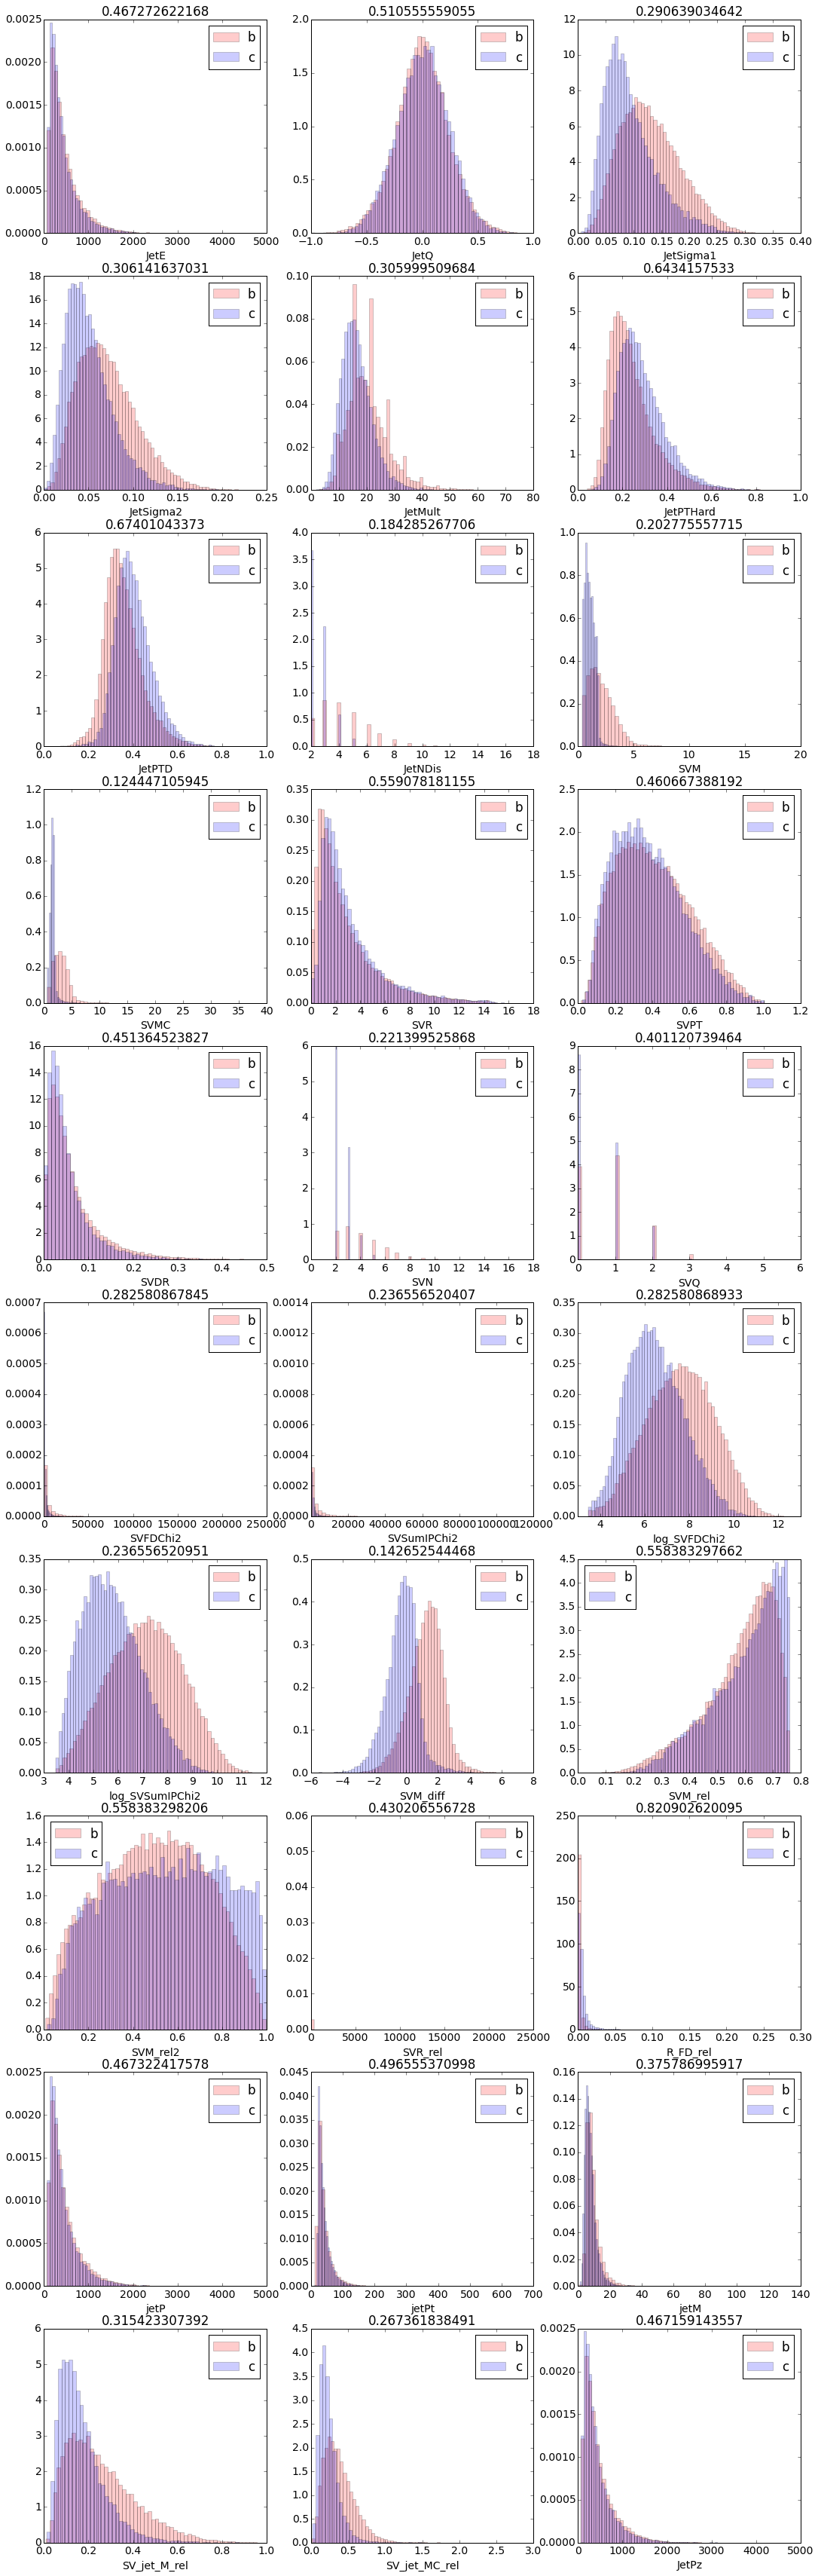

In [62]:
figsize(18, 60)
for i, feature in enumerate(data_b.columns):
    subplot(len(data_b.columns) / 3, 3, i)
    hist(data_b[feature].values, label='b', alpha=0.2, bins=60, normed=True)
    hist(data_c[feature].values, label='c', alpha=0.2, bins=60, normed=True)
#     hist(data_light[feature].values, label='light', alpha=0.2, bins=60, normed=True)
    xlabel(feature); legend(loc='best'); 
    title(roc_auc_score([0] * len(data_b) + [1]*len(data_c),
                        numpy.hstack([data_b[feature].values, data_c[feature].values])))

In [16]:
len(data_b), len(data_c), len(data_light)

(46090, 19941, 42423)

In [17]:
jet_features = jet_features[2:]

## One versus One

### Prepare datasets:
* b vs c
* b vs light
* c vs light

In [18]:
data_b_c_lds = LabeledDataStorage(pandas.concat([data_b, data_c]), [1] * len(data_b) + [0] * len(data_c))
data_c_light_lds = LabeledDataStorage(pandas.concat([data_c, data_light]), [1] * len(data_c) + [0] * len(data_light))
data_b_light_lds = LabeledDataStorage(pandas.concat([data_b, data_light]), [1] * len(data_b) + [0] * len(data_light))

In [19]:
def one_vs_one_training(base_estimators, data_b_c_lds, data_c_light_lds, data_b_light_lds, full_data, 
                        prefix='bdt', folding=True, features=None):
    if folding:        
        tt_folding_b_c = FoldingClassifier(base_estimators[0], n_folds=2, random_state=11, parallel_profile=PROFILE, 
                                           features=features)
        tt_folding_c_light = FoldingClassifier(base_estimators[1], n_folds=2, random_state=11, parallel_profile=PROFILE, 
                                               features=features)
        tt_folding_b_light = FoldingClassifier(base_estimators[2], n_folds=2, random_state=11, parallel_profile=PROFILE, 
                                               features=features)
    else:
        tt_folding_b_c = base_estimators[0]
        tt_folding_b_c.features = features
        tt_folding_c_light = base_estimators[1]
        tt_folding_c_light.features = features
        tt_folding_b_light = base_estimators[2]
        tt_folding_b_light.features = features
        
    %time tt_folding_b_c.fit_lds(data_b_c_lds)
    
    %time tt_folding_c_light.fit_lds(data_c_light_lds)

    %time tt_folding_b_light.fit_lds(data_b_light_lds)

    bdt_b_c = numpy.concatenate([tt_folding_b_c.predict_proba(pandas.concat([data_b, data_c])),
                             tt_folding_b_c.predict_proba(data_light)])[:, 1]
    bdt_c_light = numpy.concatenate([tt_folding_c_light.predict_proba(data_b), 
                                     tt_folding_c_light.predict_proba(pandas.concat([data_c, data_light]))])[:, 1]
    p_b_light = tt_folding_b_light.predict_proba(pandas.concat([data_b, data_light]))[:, 1]
    bdt_b_light = numpy.concatenate([p_b_light[:len(data_b)], tt_folding_b_light.predict_proba(data_c)[:, 1], 
                                     p_b_light[len(data_b):]])
    
    full_data[prefix + '_b_c'] = bdt_b_c
    full_data[prefix + '_b_light'] = bdt_b_light
    full_data[prefix + '_c_light'] = bdt_c_light

## Prepare stacking variables

In [20]:
full_data = pandas.concat([data_b, data_c, data_light])
full_data['label'] = [0] * len(data_b) + [1] * len(data_c) + [2] * len(data_light)

In [21]:
from hep_ml.nnet import MLPClassifier
from rep.estimators import SklearnClassifier

In [25]:
one_vs_one_training([SklearnClassifier(MLPClassifier(layers=(30, 10), epochs=700, random_state=11))]*3, 
                    data_b_c_lds, data_c_light_lds, data_b_light_lds, full_data, 'mlp', folding=True,
                    features=sv_features + additional_features + jet_features)

CPU times: user 5min 12s, sys: 4min 27s, total: 9min 40s
Wall time: 1min 4s
CPU times: user 5min 7s, sys: 4min 20s, total: 9min 28s
Wall time: 1min 2s
CPU times: user 6min 27s, sys: 5min 30s, total: 11min 58s
Wall time: 1min 20s
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)


In [27]:
from sklearn.linear_model import LogisticRegression

one_vs_one_training([LogisticRegression()]*3, 
                    data_b_c_lds, data_c_light_lds, data_b_light_lds, full_data, 
                    'logistic', folding=True, features=sv_features + additional_features + jet_features)

CPU times: user 3.22 s, sys: 0 ns, total: 3.22 s
Wall time: 3.22 s
CPU times: user 5.1 s, sys: 0 ns, total: 5.1 s
Wall time: 5.11 s
CPU times: user 4.76 s, sys: 4 ms, total: 4.77 s
Wall time: 4.78 s
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)


In [26]:
# from sklearn.svm import SVC
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler

# svm_feat = SklearnClassifier(make_pipeline(StandardScaler(), SVC(probability=True)), features=sv_features)
# %time svm_feat.fit(data_b_c_lds.data, data_b_c_lds.target)

In [28]:
# from sklearn.neighbors import KNeighborsClassifier

# one_vs_one_training([KNeighborsClassifier(metric='canberra')]*3, 
#                     data_b_c_lds, data_c_light_lds, data_b_light_lds, full_data, 
#                     'knn', folding=True, features=sv_features)

In [29]:
# from rep.estimators import TheanetsClassifier
# theanets_base = TheanetsClassifier(layers=(20, 10), trainers=[{'algo': 'adadelta', 'learining_rate': 0.1}, ])
# nn = FoldingClassifier(theanets_base, features=sv_features, random_state=11, parallel_profile='ssh-py2')
# nn.fit(full_data, full_data.label)
# multi_probs = nn.predict_proba(full_data)

In [30]:
# full_data['th_0'] = multi_probs[:, 0] / multi_probs[:, 1] 
# full_data['th_1'] = multi_probs[:, 0] / multi_probs[:, 2] 
# full_data['th_2'] = multi_probs[:, 1] / multi_probs[:, 2] 

In [31]:
mlp_features = ['mlp_b_c', 'mlp_b_light', 'mlp_c_light']
# knn_features = ['knn_b_c', 'knn_b_light', 'knn_c_light']
# th_features = ['th_0', 'th_1', 'th_2']
logistic_features = ['logistic_b_c', 'logistic_b_light', 'logistic_c_light']

# Multiclassification

In [32]:
data_multi_lds = LabeledDataStorage(full_data, 'label')

In [55]:
variables_final = set(sv_features + additional_features + jet_features + mlp_features)
# variables_final = list(variables_final - {'SVN', 'SVQ', 'log_SVFDChi2', 'log_SVSumIPChi2', 'SVM_rel2', 'JetE', 'JetNDis'})

In [67]:
from rep.estimators import XGBoostClassifier

xgb_base = XGBoostClassifier(n_estimators=3000, colsample=0.7, eta=0.005, nthreads=8, 
                             subsample=0.7, max_depth=6)

multi_folding_rbf = FoldingClassifier(xgb_base, n_folds=2, random_state=11, 
                                      features=variables_final)
%time multi_folding_rbf.fit_lds(data_multi_lds)

CPU times: user 1h 2s, sys: 2.9 s, total: 1h 5s
Wall time: 7min 34s


FoldingClassifier(base_estimator=XGBoostClassifier(base_score=0.5, colsample=0.7, eta=0.005, features=None,
         gamma=None, max_depth=6, min_child_weight=1.0, missing=-999.0,
         n_estimators=3000, nthreads=8, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.7, verbose=0),
         features=set(['SVR_rel', 'JetNDis', 'JetPTHard', 'SVPT', 'mlp_c_light', 'SVM_diff', 'SVSumIPChi2', 'mlp_b_c', 'JetSigma2', 'JetQ', 'JetSigma1', 'log_SVFDChi2', 'R_FD_rel', 'SVMC', 'SV_jet_M_rel', 'SVN', 'SVM', 'SVM_rel2', 'log_SVSumIPChi2', 'jetPt', 'SVDR', 'SVM_rel', 'JetE', 'JetPTD', 'SVR', 'SVQ', 'JetPz', 'jetM', 'JetMult', 'mlp_b_light', 'SV_jet_MC_rel', 'jetP', 'SVFDChi2']),
         n_folds=2, parallel_profile=None, random_state=11)

In [68]:
multi_probs = multi_folding_rbf.predict_proba(full_data)
'log loss', -numpy.log(multi_probs[numpy.arange(len(multi_probs)), full_data['label']]).sum() / len(full_data)

KFold prediction using folds column


('log loss', 0.22569323022675056)

In [69]:
multi_folding_rbf.get_feature_importances()

,effect
SVR_rel,0.528336
JetNDis,0.134713
JetPTHard,0.460868
SVPT,0.640399
mlp_c_light,0.831710
SVM_diff,0.474094
SVSumIPChi2,0.592669
mlp_b_c,1.000000
JetSigma2,0.538613
JetQ,0.605153


In [70]:
labels = full_data['label'].values.astype(int)
multiclass_result = generate_result(1 - roc_auc_score(labels > 0, multi_probs[:, 0] / multi_probs[:, 1], 
                                                      sample_weight=(labels != 2) * 1),
                                    1 - roc_auc_score(labels > 1, multi_probs[:, 0] / multi_probs[:, 2],
                                                      sample_weight=(labels != 1) * 1),
                                    1 - roc_auc_score(labels > 1, multi_probs[:, 1] / multi_probs[:, 2],
                                                      sample_weight=(labels != 0) * 1),
                                    label='multiclass')

result = pandas.concat([multiclass_result])
result.index = result['name']
result = result.drop('name', axis=1)
result



,b vs c,b vs light,c vs light
name,,,
multiclass,0.96358,0.996209,0.988789


Previous models:

* my 0.949379	0.988952	0.981269 (0.30178466234823914)
* mikhail 0.951279	0.987887	0.98012
* pasha 0.95139229,  0.9888575 ,  0.98096004

Jet features:

* 0.962638	0.996292	0.989241 (0.2265288348457582)
* 0.962929	0.9967	0.988472  (0.22570645895188746) (with additional)
* 0.963468	0.996211	0.988844 (0.22622155319396442) (with MLP, additional)

* 0.96358 0.996209 0.988789 (0.22569323022675056  n_estimators=3000, colsample=0.7, eta=0.005, nthreads=8, subsample=0.7, max_depth=6)